# Session 03 - Temporal Difference Learning - Assignment

## Generic functions

In [4]:
# Cliff walking

import gymgrid2 #pip install gymgrid
import numpy as np
import gym


In [5]:
import numpy as np
from matplotlib import pyplot as plt

def plot_mov_avg(value_list: list, n: int=10):
    values = np.array(value_list)
    cumsum = np.cumsum(np.insert(values, 0, 0)) 
    moving_averages = (cumsum[n:] - cumsum[:-n]) / float(n)
    plt.plot(value_list)
    plt.plot(moving_averages)

In [6]:
import pygame

def render_board(env, episode: int, epoch: int):
    #return
    #os.system('clear')
    pygame.display.set_caption(f'Episode {episode+1}')
    #print(f"Episode #{episode}")
    #print(f"Epoch #{epoch}")
    env.render()

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Cliff walking

Implement Q-learning and SARSA to solve the cliff walking environment. The cliff walking environment is part of the gymgrid package. 
To install gymgryd: **pip3 install gymgrid**. More information can be found here: https://pypi.org/project/gymgrid/.
The goal for the agent is to find its way from start to finish without falling from the cliff. This is a standard episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked Cliff. Stepping into this region incurs a reward of optimal path -100 and sends the agent instantly back to the start.

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
> **See below.  All parameters are used and available, not much time for tuning though**
    
- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
> **See below.  Plotted all results**

- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
> **This is easily possible, by applying same logic as for decaying epsilon value.  As the path was easily found, it normally will have even faster results, by adapting the alpha**

- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.
> **I adapted the logic to give a bigger reward when completing the final state, which results in larger Q values for the correct actions**

- Modify you Q-learing implementation to a SARSA implementation.
> **See below, mostly the bellman equation is where the changes were**

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 
> **Sarsa takes a 'safer' path, which results in more actions to be taken, typically.  Q-learning will use less actions and therefore is more risky, especially when the environment can have dynamic behavior.  But the learning is faster with the greedy approach, typically**

### Q Learning

In [40]:
class CliffQAgent:
    
    def __init__(self, env, alpha, gamma, epsilon, decay):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.nr_states = env.observation_space.n
        self.nr_actions = env.action_space.n
        self.state = 0
        self.possible_actions = range(env.action_space.n)
        self.q_table = np.zeros((self.nr_states, self.nr_actions))
  
        
    def compute_action(self, state, debug: bool = False):
        from random import sample
        import random
    
        self.state = state
        self.epsilon = self.epsilon * self.decay
        if np.random.uniform() < epsilon:
            if debug:
                print(f'Explore - {self.r} < {self.epsilon}')
            self.action = random.choice(self.possible_actions)
        else:
            if debug:
                print(f'Exploit - {self.r} > {self.epsilon}')
            self.action = np.argmax(self.q_table[state,:])

        return self.action
    
    def update_qtable(self, state, new_state, reward):
        self.reward = reward
        self.state = state
        self.new_state = new_state

        # Bellman equation
        old_q_value = self.q_table[state, action]
        new_q_value = ((1-self.alpha) * old_q_value) + (self.alpha * (reward + (self.gamma * max(self.q_table[new_state,:]))))

        self.q_table[state, self.action] = new_q_value
        
        

0

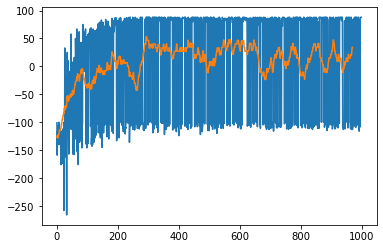

In [41]:
nr_of_episodes = 1000
alpha = 0.2
gamma = 0.3
decay = 1 # no decay = 1
epsilon = 0.15
debug = False
render_rate = 2000

# load the environment
env = gym.make('cliff-v0')
state = env.reset()

q_agent = CliffQAgent(env, alpha, gamma, epsilon, decay)
episode_awards = list()

for n in range(nr_of_episodes):
    episode_award = 0
    state = env.reset()
    new_state = state
    for t in range(200):
        
        action = q_agent.compute_action(state, debug)
        new_state, reward, done, _ =  env.step(action)
        q_agent.update_qtable(state, new_state, reward)
        
        state = new_state
        if reward == 0 :
            # Making sure the completion of the level results in a large reward
            reward = 100 
        episode_award += reward
        if reward <= -100 or reward >= 0:
            # Strange issue that is not setting the done variable correctly, so working around this
            if debug:
                print(f'Episode {n+1} completed with episode_award {episode_award} reward {reward}!')
            # Show where board finished
            render_board(env, n, t)
            break
        

    render_board(env, n, t)
    episode_awards.append(episode_award)

plot_mov_avg(episode_awards, 30)
env.reset()

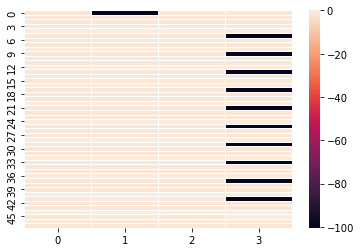

In [42]:
# Plotting a heatmap of the q table
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


ax = sns.heatmap(q_agent.q_table, linewidth=0.5)
plt.show()

### Sarsa implementation

In [20]:
from random import sample
import random

class CliffSarsaAgent:
    def __init__(self, env, alpha, gamma, epsilon, decay):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.nr_states = env.observation_space.n
        self.nr_actions = env.action_space.n
        self.state = 0
        self.possible_actions = range(env.action_space.n)
        self.q_table = np.zeros((self.nr_states, self.nr_actions))
        self.action = random.choice(self.possible_actions)
        
    def compute_action(self, state, debug: bool = False):
        self.state = state
        self.epsilon = self.epsilon * self.decay
        self.previous_action = self.action
        self.r = np.random.uniform()
        if self.r < epsilon:
            self.action = random.choice(self.possible_actions)
        else:
            self.action = np.argmax(self.q_table[state,:])
        
        return self.action
    
    def update_qtable(self, state, new_state, reward):
        self.reward = reward
        self.state = state
        self.new_state = new_state

        # Bellman equation
        predict_value = self.q_table[state, action]
        target_value = reward + (self.gamma * self.q_table[new_state,self.previous_action])
        self.q_table[state, self.action] = self.q_table[state, self.action] + alpha * (target_value - predict_value)
   

In [21]:
nr_of_episodes = 1000
alpha = 0.2
gamma = 0.3
decay = 1 # no decay = 1
epsilon = 0.15
debug = False
render_rate = 2000

# load the environment
env = gym.make('cliff-v0')
state = env.reset()



In [22]:
q_agent = CliffSarsaAgent(env, alpha, gamma, epsilon, decay)
episode_awards = list()

0

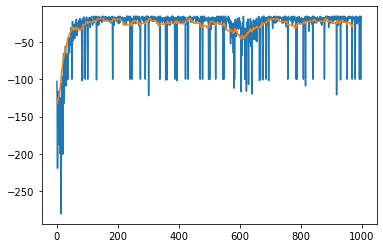

In [23]:
for n in range(nr_of_episodes):
    episode_award = 0
    state = env.reset()
    new_state = state
    for t in range(200):
        action = q_agent.compute_action(state, debug)
        new_state, reward, done, _ =  env.step(action)
        episode_award += reward
        q_agent.update_qtable(state, new_state, reward)
        
        state = new_state
        if reward == 0 :
            # Making sure the completion of the level results in a large reward
            reward = 100 
        if reward <= -100 or reward >= 0:
            # Strange issue that is not setting the done variable correctly, so working around this
            if debug:
                print(f'Episode {n+1} completed with episode_award {episode_award} reward {reward}!')
            # Show where board finished
            render_board(env, n, t)
            break
        

    render_board(env, n, t)
    episode_awards.append(episode_award)

plot_mov_avg(episode_awards, 30)
env.reset()

## The cartpole environment

Solve the cartpole environment by means of both Q-learning and SARSA. 
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

Q-learing and SARSA take discrete states as inputs. The cartpole environments outputs continuous state vectors. 
Therefore you will have to discretize these continuous state vectors. 
For example the cart position can vary in the range of -2.4 -> 2.4. You will have to discretize this range in a number of bins (for example 10 bins).
The numpy function 'digitize' can be used for discretization. More information about this function: https://numpy.org/doc/stable/reference/generated/numpy.digitize.html

- Implement the Q-learning algorithm. Write your own implementation and tune the hyperparameters (learning rate, discount factor, epsilon). Use epsilon decay if necessary. 
> **I have to be honest that time was too limited to get this tuned well.  However, I have added both agents, and used the four state-variables (position, velocity, angle, angle_velocity) to create a 5D matrix, with a configurable number of bins.  That's definitely where there's more tuning and testing needed.  I just hope the logic I applied makes sense enough, to show I understand the approach**

- Record the learning history. This means that for each episode you register the total episodic reward. After learning, plot the training history (x-axis = episode number; y-axis: total episodic reward). Especially in the beginning, the episodic rewards can be erratic because the agent is still exploring and has little knowledge of the environment. Therefore it can be a good idea to plot the moving average of the episodic rewards. For example, the average episodic reward achieved over 10 episodes.
> **Same as above**

- Check if you can make the agent learn faster by using an adaptive learning rate. You start with a high learning rate and you decrease gradually as the agent learns.
> **Same as above**

- Can you change the reward function in order to make the agent learn faster. For example by changing the reward values or by adding new rewards that make the reward function less sparse.
> **Same as above**

- Modify you Q-learing implementation to a SARSA implementation.
> **See below**

- Compare Q-learing with SARSA in terms of speed of learning, but especially in terms of the learned policy. 
> **Same as above**

### Cartpole Q learning

In [7]:
from random import sample
import random

class PoleQAgent:
    def __init__(self, nr_pos_bins, nr_velocity_bins, nr_angle_bins, nr_angle_vel_bins, nr_actions, alpha, gamma, epsilon, decay):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.nr_pos_bins = nr_pos_bins
        self.nr_velocity_bins = nr_velocity_bins
        self.nr_angle_bins = nr_angle_bins
        self.nr_angle_vel_bins = nr_angle_vel_bins
        self.nr_actions = nr_actions
        self.state = 0
        self.possible_actions = [0, 1]
        self.q_table = np.zeros((nr_pos_bins, nr_velocity_bins, nr_angle_bins, nr_angle_vel_bins, nr_actions))
  
        
    def compute_action(self, state):
        #state is 1x4 array: position, velocity, angle, angle_velocity
        self.state = state
        self.epsilon = self.epsilon * self.decay
        self.r = np.random.uniform()
        
        position_bin = np.digitize(state, np.linspace(-2.4, 2.4, self.nr_pos_bins))[0]
        vel_bin = np.digitize(state, np.linspace(-3, 3, self.nr_velocity_bins))[1]
        angle_bin = np.digitize(state, np.linspace(-.21, .21, self.nr_angle_bins))[2]
        angle_vel_bin = np.digitize(state, np.linspace(-4, 4, self.nr_angle_vel_bins))[3]
        
        
        if self.r <= self.epsilon:
            self.action = random.choice(self.possible_actions)
        else:
            self.action = np.argmax(self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin,:])

        return self.action
    
    def update_qtable(self, state, new_state, reward):
        self.reward = reward
        self.state = state
        self.new_state = new_state

        position_bin = np.digitize(state, np.linspace(-2.4, 2.4, self.nr_pos_bins))[0]
        vel_bin = np.digitize(state, np.linspace(-3, 3, self.nr_velocity_bins))[1]
        angle_bin = np.digitize(state, np.linspace(-.21, .21, self.nr_angle_bins))[2]
        angle_vel_bin = np.digitize(state, np.linspace(-4, 4, self.nr_angle_vel_bins))[3]

        # Bellman equation
        old_q_value = self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin, action]
        new_q_value = ((1-self.alpha) * old_q_value) + (self.alpha * (reward + (self.gamma * max(self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin,:]))))

        self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin, action] = new_q_value

In [8]:
# Solving the cartpole environment

env_name = "CartPole-v0"
env = gym.make(env_name)
env.reset()
nr_actions = 2

array([-0.01700365,  0.02369071, -0.01090096,  0.01015985], dtype=float32)

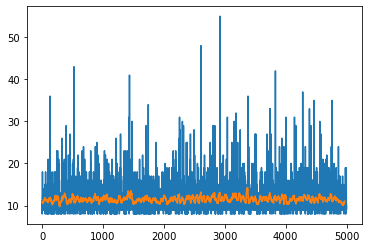

In [12]:
nr_of_episodes = 5000
alpha = 0.2
gamma = 0.3
decay = 1 # no decay = 1
epsilon = 0.15
debug = False
render_rate = 2000

pos_bins = 2
vel_bins = 20
angle_bins = 40
angvel_bins = 10

render_rate = 20

q_agent = PoleQAgent(pos_bins, vel_bins, angle_bins, angvel_bins, nr_actions, alpha, gamma, epsilon, decay)
episode_awards = list()

for n in range(nr_of_episodes):
    episode_award = 0
    state = env.reset()
    new_state = state
    for t in range(200):
        action = q_agent.compute_action(state)
        new_state, reward, done, _ =  env.step(action)
        episode_award += reward
        if t % render_rate == 0:
            render_board(env, n, t)
        q_agent.update_qtable(state, new_state, reward)
        state = new_state
        
        if done == True:
            break

    episode_awards.append(episode_award)

plot_mov_avg(episode_awards, 30)
env.reset()

### Cartpole SARSA

In [18]:
from random import sample
import random

class PoleSarsaAgent:
    def __init__(self, nr_pos_bins, nr_velocity_bins, nr_angle_bins, nr_angle_vel_bins, nr_actions, alpha, gamma, epsilon, decay):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay = decay
        self.nr_pos_bins = nr_pos_bins
        self.nr_velocity_bins = nr_velocity_bins
        self.nr_angle_bins = nr_angle_bins
        self.nr_angle_vel_bins = nr_angle_vel_bins
        self.nr_actions = nr_actions
        self.state = 0
        self.possible_actions = [0, 1]
        self.q_table = np.zeros((nr_pos_bins, nr_velocity_bins, nr_angle_bins, nr_angle_vel_bins, nr_actions))
        self.action = 0
        
    def compute_action(self, state):
        #state is 1x4 array: position, velocity, angle, angle_velocity
        self.state = state
        self.epsilon = self.epsilon * self.decay
        self.r = np.random.uniform()
        self.previous_action = self.action
        
        position_bin = np.digitize(state, np.linspace(-2.4, 2.4, self.nr_pos_bins))[0]
        vel_bin = np.digitize(state, np.linspace(-3, 3, self.nr_velocity_bins))[1]
        angle_bin = np.digitize(state, np.linspace(-.21, .21, self.nr_angle_bins))[2]
        angle_vel_bin = np.digitize(state, np.linspace(-4, 4, self.nr_angle_vel_bins))[3]
        
        
        if self.r <= self.epsilon:
            self.action = random.choice(self.possible_actions)
        else:
            self.action = np.argmax(self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin,:])

        return self.action
    
    def update_qtable(self, state, new_state, reward):
        self.reward = reward
        self.state = state
        self.new_state = new_state

        position_bin = np.digitize(state, np.linspace(-2.4, 2.4, self.nr_pos_bins))[0]
        vel_bin = np.digitize(state, np.linspace(-3, 3, self.nr_velocity_bins))[1]
        angle_bin = np.digitize(state, np.linspace(-.21, .21, self.nr_angle_bins))[2]
        angle_vel_bin = np.digitize(state, np.linspace(-4, 4, self.nr_angle_vel_bins))[3]

        # Bellman equation
        predict_value = self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin, action]
        target_value = reward + (self.gamma * self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin,self.previous_action])
        self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin, action] = self.q_table[position_bin, vel_bin, angle_bin, angle_vel_bin, action] + alpha * (target_value - predict_value)


array([ 0.02444352, -0.04521655, -0.00868474,  0.00803403], dtype=float32)

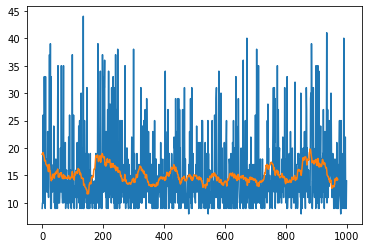

In [19]:
nr_of_episodes = 1000
alpha = 0.2
gamma = 0.3
decay = 1 # no decay = 1
epsilon = 0.15
debug = False
render_rate = 2000

pos_bins = 2
vel_bins = 20
angle_bins = 40
angvel_bins = 10

render_rate = 20

q_agent = PoleSarsaAgent(pos_bins, vel_bins, angle_bins, angvel_bins, nr_actions, alpha, gamma, epsilon, decay)
episode_awards = list()

for n in range(nr_of_episodes):
    episode_award = 0
    state = env.reset()
    new_state = state
    for t in range(200):
        action = q_agent.compute_action(state)
        new_state, reward, done, _ =  env.step(action)
        episode_award += reward
        if t % render_rate == 0:
            render_board(env, n, t)
        q_agent.update_qtable(state, new_state, reward)
        state = new_state
        
        if done == True:
            break

    episode_awards.append(episode_award)

plot_mov_avg(episode_awards, 30)
env.reset()